Solaris installation with gdal\
!add-apt-repository ppa:ubuntugis/ppa -y\
!apt-get update\
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

In [ ]:
!pip3 install torch torchvision
!pip3 install py7zr
!pip3 install rasterio
!pip3 install --upgrade earthpy

Solaris installation

In [ ]:
!add-apt-repository ppa:ubuntugis/ppa -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

In [ ]:
#python imports
import py7zr
import os
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt

#earth observation python lib imports
import rasterio
import solaris as sol
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

#pytorch imports
import torch
from torch import nn
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models.vgg import VGG

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


load dataset from github\
repo path : https://github.com/AnupamaRajkumar/LandfillDataset.git


In [ ]:
#!apt-get update && apt-get upgrade
#!apt-get install git-lfs

Use this if downloading from git (ie. LFS quota available!)

In [ ]:
#!git lfs clone https://github.com/AnupamaRajkumar/LandfillDataset.git

Declaring paths

In [ ]:

#All the paths related to multispectral dataset
Multispectral_path = './Multispectral.7z'                                       #path of zip files
TIF_file_path = './MultiSpectral/HR_TIF_Files.7z'
JSON_file_path = './MultiSpectral/LandfillCoordPolygons.7z'
json_path = './LandfillCoordPolygons'
train_path = './HR_TIF_Files'
train_labels = './MultiSpectral/MultiSpectralData.csv'

#All the paths related to pansharpened datset
Pansharpened_path = './Pansharpened.7z'
PanSharpened_TIF_file_path = './Pansharpened/HR_TIF_Files.7z'
PanSharpened_JSON_file_path = './Pansharpened/LandfillCoordPolygons.7z'
train_labels = './Pansharpened/PanSharpenedData.csv'
#Output directory path
out_path = './'                                                                 #output path of extracted files

#dimensions of the figure to be displayed
width = 15
height = 15
num_images = 6

Extract the images from zip folder

In [ ]:
def ExtractFiles(in_path, out_path):
  with py7zr.SevenZipFile(in_path, mode='r') as z:
    z.extractall(out_path)

Use following functions downloading dataset from dropbox

Multispectral dataset

In [ ]:
def DownloadMultiSpectralDataset():
  !wget https://www.dropbox.com/s/2r0b8goiytyh0fc/MultiSpectral.7z?dl=0
  os.rename('MultiSpectral.7z?dl=0', 'Multispectral.7z')
  ExtractFiles('Multispectral.7z', out_path)

Pansharpened dataset

In [ ]:
def DownloadPanSharpenedDataset():
  !wget https://www.dropbox.com/s/y048lu2ehtsmo3r/Pansharpened.7z?dl=0
  os.rename('Pansharpened.7z?dl=0', 'Pansharpened.7z')
  ExtractFiles('Pansharpened.7z', out_path)
  #os.rmdir(Pansharpened_path)

In [ ]:
#DownloadMultiSpectralDataset()
DownloadPanSharpenedDataset()

--2021-04-21 03:21:32--  https://www.dropbox.com/s/y048lu2ehtsmo3r/Pansharpened.7z?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/y048lu2ehtsmo3r/Pansharpened.7z [following]
--2021-04-21 03:21:32--  https://www.dropbox.com/s/raw/y048lu2ehtsmo3r/Pansharpened.7z
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce4178f5d46ce116f28be1fce39.dl.dropboxusercontent.com/cd/0/inline/BNCcXAFRs7owHqVlmlAImQPQ09KECqglQk0wdGckGp2Xadx--nrTdBhjvfyvvwKh-dEBOBiZ6qA10dwwPjMwXVcS55HgYDulTG2Hqqo9gfMvfzu0lRqOMQN61uhLTlxgKTWVJfjKA4aMspM4nHT37vs3/file# [following]
--2021-04-21 03:21:32--  https://uce4178f5d46ce116f28be1fce39.dl.dropboxusercontent.com/cd/0/inline/BNCcXAFRs7owHqVlmlAImQPQ09KECqglQk0wdGckGp2Xadx--nrTdBhjvfyvvwKh-dEBOBiZ6

Extracting the multispectral dataset\
Run this cell if working with multispectral dataset

In [ ]:
"""
  #extract multispectral images
  ExtractFiles(TIF_file_path , out_path)
  #extract multispectral json files
  ExtractFiles(JSON_file_path , out_path)
"""

'\n  #extract multispectral images\n  ExtractFiles(TIF_file_path , out_path)\n  #extract multispectral json files\n  ExtractFiles(JSON_file_path , out_path)\n'

Extracting the pansharpened dataset\
Run this cell if working with pansharpened dataset

In [ ]:
  #extract pansharpened images
  ExtractFiles(PanSharpened_TIF_file_path , out_path)
  #extract multispectral json files
  ExtractFiles(PanSharpened_JSON_file_path , out_path)

In [ ]:
def im_convert(image_name, channels):
  image = rasterio.open(os.path.join(train_path, image_name)).read()
  #false color composite visualisation
  if(channels == 8):
    raster = np.dstack((image[4,:,:], image[2,:,:],image[1,:,:])) 
  elif(channels == 4):
    raster = np.dstack((image[2,:,:], image[1,:,:],image[0,:,:]))
  return raster

Displaying a few images from the folder

Number of images images: 242
-------------multispectral images----------------
image :  00220_Vinca_Serbia.tif channels : 8


<Figure size 1800x1800 with 0 Axes>

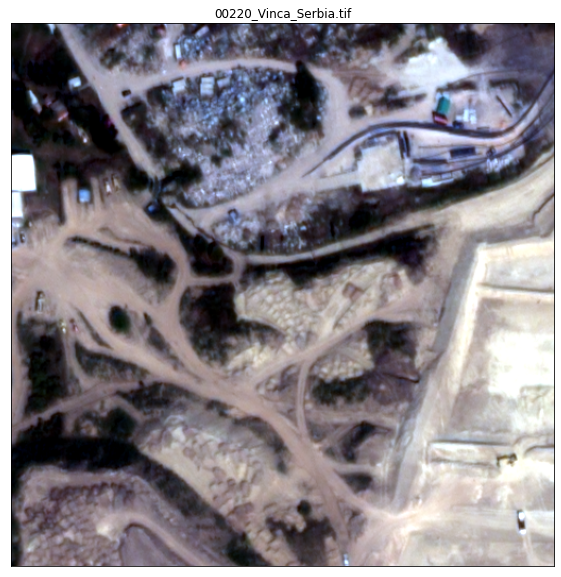

image :  00140_Mumbai_India.tif channels : 4


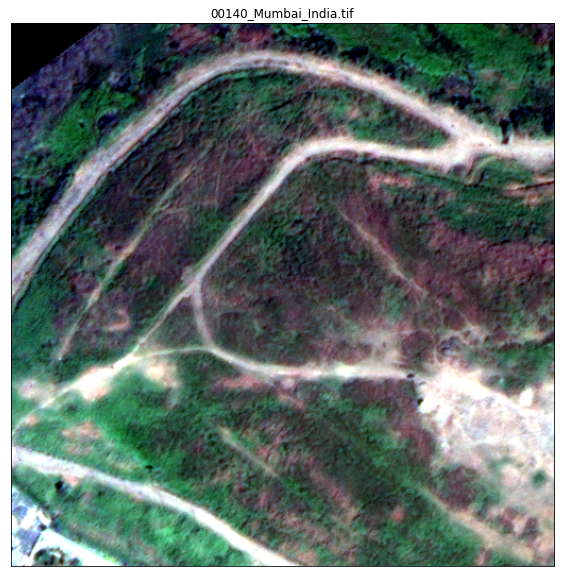

image :  00162_Nurnberg_Germany.tif channels : 4


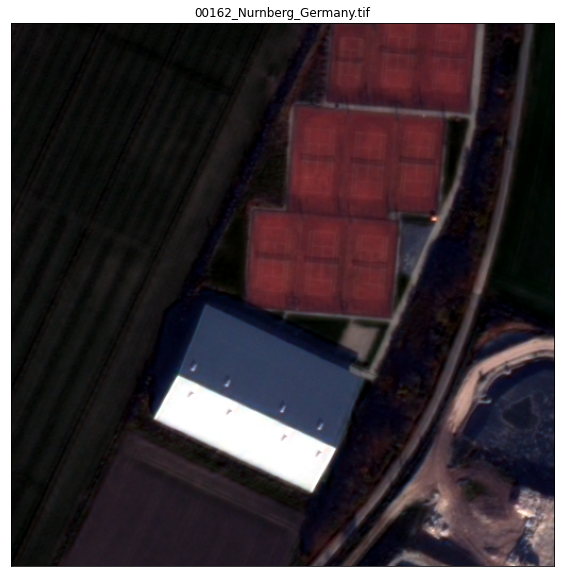

image :  00183_Rio_Brazil.tif channels : 4


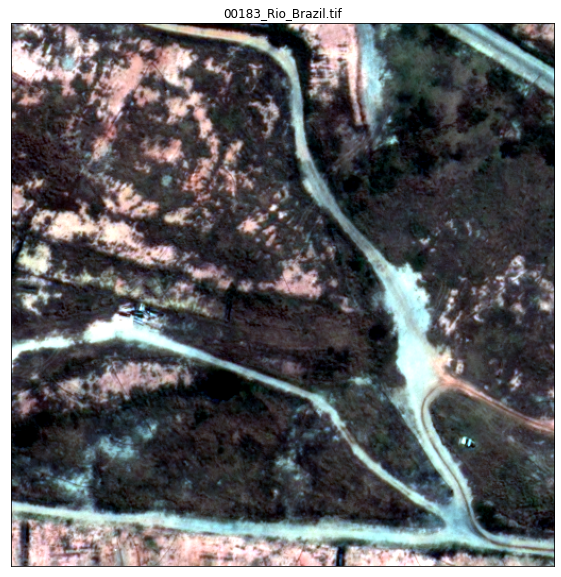

image :  00205_Tatabanya_Hungary.tif channels : 8


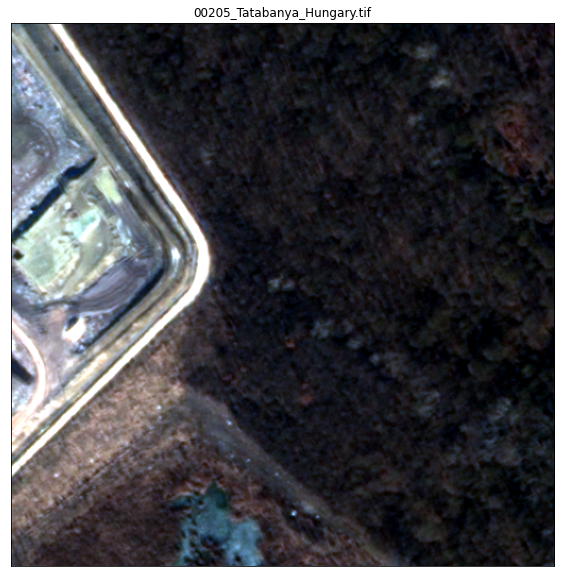

image :  00100_God_Hungary.tif channels : 8


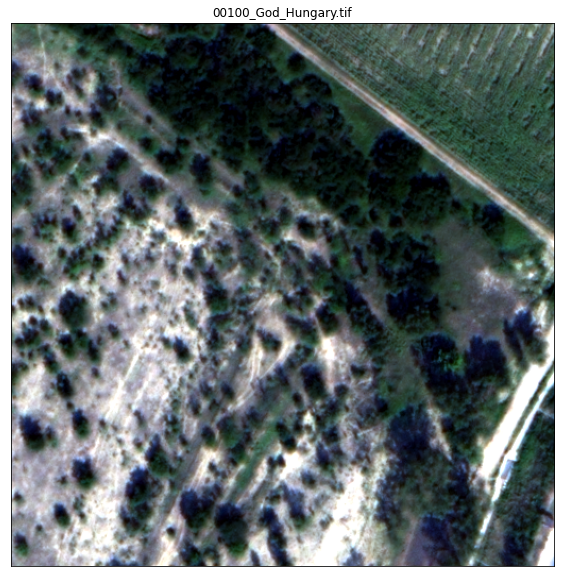

In [ ]:
train_files = os.listdir(train_path)

num_of_train_images = len([name for name in train_files if os.path.isfile(os.path.join(train_path, name))])
print("Number of images images:", num_of_train_images)
selected = np.random.choice(num_of_train_images, num_images)

fig = plt.figure(figsize = (25,25))
print('-------------multispectral images----------------')

for i, ind in enumerate(selected):
  raster_arr = rasterio.open(os.path.join(train_path, train_files[ind])).read()
  channels = raster_arr.shape[0]
  print("image : " , train_files[ind], "channels :", channels)
  #false color composite visualisation
  if(channels == 8):
    rgb = (4,2,1)             #R, G, B bands
  elif(channels == 4):
    rgb = (2,1,0)             #R, G, B bands

  ep.plot_rgb(raster_arr, rgb=rgb, stretch=True, title=train_files[ind])
  plt.show()
  #plt.imshow(raster_fcc)
  #plt.title(train_files[ind])

Loading the dataset from the split dataset

referred from:\
https://github.com/tkshnkmr/frcnn_medium_sample,
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Checking the proportion of data classes in the dataset

In [ ]:
dataFrame = pd.read_csv(train_labels, usecols=["Idx", "Image Index", "IsLandfill"])
data = dataFrame.values.tolist()
label = pd.read_csv(train_labels, usecols=["IsLandfill"])


def get_class_count(data):
  grp = data.groupby(["IsLandfill"]).nunique()
  return{key : grp[key] for key in list(grp.keys())}

def get_class_proportion(data):
  class_count = get_class_count(data)
  return {val[0]: round(val[1]/data.shape[0], 4) for val in class_count.items()}

#print("Dataset class counts:", get_class_count(dataFrame))
print("Dataset class proportions:", get_class_proportion(dataFrame))

Dataset class proportions: {'Idx': IsLandfill
1    1.0
Name: Idx, dtype: float64, 'Image Index': IsLandfill
1    1.0
Name: Image Index, dtype: float64}


Tackling the imabalanced dataset
1. Undersampling : Randomly delete some observations from the majority class in order to match the numbers with the minority class. Suitable when there is a lot of data
2. Oversampling : Add copies of instances from under-represented class. Suitable for smaller dataset

We will use random over-sampling as we have a small set of data - TBD

Stratified and random split into train, test and validation datasets

In [ ]:
train_ratio = 0.70
test_ratio = 0.30
#validation_ratio = 0.10

train_idx, test_idx, train_lab, test_lab = train_test_split(dataFrame, label, 
                                                            test_size = test_ratio, 
                                                            shuffle=True, stratify=label)

"""
train_idx, val_idx, train_lab, val_lab = train_test_split(train_idx, train_lab,
                                                          test_size = validation_ratio,
                                                          shuffle=True, stratify=train_lab)
"""


print("Train size is {}, test size is {}".format(len(train_idx), len(test_idx)))

print("****************Dataset proportion after stratified splitting***************")
print("Train data class proportions:", get_class_proportion(train_idx))
print("Test data class proportions:", get_class_proportion(test_idx))

Train size is 169, test size is 73
****************Dataset proportion after stratified splitting***************
Train data class proportions: {'Idx': IsLandfill
1    1.0
Name: Idx, dtype: float64, 'Image Index': IsLandfill
1    1.0
Name: Image Index, dtype: float64}
Test data class proportions: {'Idx': IsLandfill
1    1.0
Name: Idx, dtype: float64, 'Image Index': IsLandfill
1    1.0
Name: Image Index, dtype: float64}


In [ ]:
#parameters
batch_size = 10
num_workers = 1
num_classes = 2       #landfill or background
epochs = 100
lr = 1e-3
w_decay = 1e-5
momentum = 0.9
step_size = 25
gamma = 0.5
image_size = 512
patch_width = 512
patch_height= 512

Create custom transforms to perform data augmentation in the class

In [ ]:
class CustomLandfillDataset(torch.utils.data.Dataset):
  def __init__(self, data, transforms=None, num_classes=num_classes):                             #transforms
    self.data = data
    #self.transforms = transforms
    self.json_frame = pd.read_csv(train_labels, usecols=["json index"])
    self.isLandfillList = pd.read_csv(train_labels, usecols=["IsLandfill"]).values.tolist()
    self.num_classes = num_classes

  def transform(self, image, mask):
    #convert image and mask to PIL Images
    image = TF.to_pil_image(image)
    mask = TF.to_pil_image(mask)

    #random horizontal flip
    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    #random vertical flip
    if random.random() > 0.5:
      image = TF.vflip(image)
      mask = TF.vflip(mask)

    #random rotation
    image = TF.rotate(image, angle=10.0)
    mask = TF.rotate(mask, angle=10.0)

    image = TF.rotate(image, angle=20.0)
    mask = TF.rotate(mask, angle=20.0)

    #convert PIL image and mask to tensor before returning
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)

    #normalise the image as per mean and std dev
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    return image, mask

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #image id
    img_id = self.data[index][0]
    #path for image
    img_name = self.data[index][1]
    #read the image to extract number of channels
    raster_img = rasterio.open(os.path.join(train_path, img_name)).read()
    #change datatype of image from uint16 to int32
    raster_img = raster_img.astype('uint8')
    #print(raster_img.shape)
    raster_channels = raster_img.shape[0]
    #mask
    json_list = self.json_frame.values.tolist()
    json_name = json_list[img_id-1][0]
    IsLandfill = self.isLandfillList[img_id-1][0]
    if(IsLandfill):
      fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(json_path, json_name), 
                                               reference_im=os.path.join(train_path, img_name))
      fp_mask = fp_mask.astype('uint8')
    else:
      fp_mask = np.zeros((patch_height, patch_width), dtype=np.uint8)

    rgb_image = raster_img.transpose(1,2,0)         
    if(raster_channels == 8):
      rgb_image = np.dstack((raster_img[4,:,:], 
                             raster_img[2,:,:], 
                             raster_img[1,:,:]))
    elif(raster_channels == 4):
      rgb_image = np.dstack((raster_img[2,:,:], 
                             raster_img[1,:,:], 
                             raster_img[0,:,:]))
      

    min = np.min(rgb_image)
    max = np.max(rgb_image)
    #before normalisation, the image should be brought into a 0 - 1 range (standardisation)
    rgb_image = ((rgb_image - min) / (max - min)).astype('uint8')
    
    #print(image.shape, fp_mask.shape)
    rgb_image, fp_mask = self.transform(rgb_image, fp_mask)
    rgb_image_resized = rgb_image.detach().numpy()

    #in case the image is smaller than 512x512
    if((rgb_image.shape[1] < patch_height) or (rgb_image.shape[2] < patch_width)):
      rgb_image_resized = np.zeros((patch_height, patch_width), dtype=np.uint8)
      rgb_image_resized[0:rgb_image.shape[1], 0:rgb_image.shape[2]] = rgb_image[0,:,:]
      rgb_image_resized = np.expand_dims(rgb_image_resized, axis=0)
      for c in range(rgb_image.shape[0]-1):
        resized_raster = np.zeros((patch_height, patch_width), dtype=np.uint8)
        resized_raster[0:rgb_image.shape[1], 0:rgb_image.shape[2]] = rgb_image[c+1,:,:]
        resized_raster = np.expand_dims(resized_raster,axis=0)
        rgb_image_resized = np.vstack((rgb_image_resized, resized_raster)) 

    #rgb_image_resized = rgb_image_resized.astype('uint8')
    #create another mask variable

    mask = fp_mask
    mask = mask.detach().numpy().squeeze()

    #in case the mask size is smaller than 512x512
    if((fp_mask.shape[1] < patch_height) or (fp_mask.shape[2] < patch_width)):
      mask = np.zeros((patch_height, patch_width), dtype=np.int8)
      mask[0:fp_mask.shape[1], 0:fp_mask.shape[2]] = fp_mask
    #one hot encoding of the mask depending on the number of classes
    mask_hotEnc = torch.zeros(self.num_classes, patch_height, patch_width)
    for n in range(self.num_classes):
      mask_hotEnc[n][mask==n] = 1

    rgb_image_resized = rgb_image_resized.astype('float32')
    mask = mask.astype('float32')
    mask_hotEnc = mask_hotEnc.detach().numpy().astype('float32')

    img_info = {}
    img_info["RGBimage"] = rgb_image_resized
    img_info["mask"] = mask
    img_info["maskHotEnc"] = mask_hotEnc
    img_info["channels"] = raster_channels
    img_info["name"] = img_name
    img_info["image_id"] = img_id

    return img_info

Create respective train and test datasets and create a dataloader

In [ ]:
#train_idx and test_idx are dataframes
train_dataset = CustomLandfillDataset(data=train_idx.values.tolist(), transforms=None)                               
test_dataset = CustomLandfillDataset(data=test_idx.values.tolist(), transforms=None)                                

#data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

print("length of training dataset:", len(train_dataset))
print("length of test dataset:", len(test_dataset))
print("length of training loader:", len(train_loader))
print("length of test loader:", len(test_loader))

length of training dataset: 169
length of test dataset: 73
length of training loader: 17
length of test loader: 8


Checking out some images and their corresponding masks

In [ ]:
img_info = next(iter(train_loader))

rgb_img = img_info['RGBimage']
mask = img_info['mask']
mask_hotEnc = img_info['maskHotEnc']
channels = img_info['channels']

print("image mask:", mask.shape, "channels:", channels)
print("transformed image shape:", rgb_img.shape, "hot encoded mask:", mask_hotEnc.shape)
print("image dtype:", rgb_img.dtype, " mask dtype:", mask.dtype, " hot encoded dtype:", mask_hotEnc.dtype)
#check the min and max values of the image and mask to check if it is standardised and normalised
rgbArr = rgb_img[0].detach().numpy()
maskArr = mask_hotEnc[0].detach().numpy()
print("Min value of image:", np.min(rgbArr), " Max value of image:", np.max(rgbArr))
print("Min value of mask:", np.min(maskArr), " Max value of mask:", np.max(maskArr))

image mask: torch.Size([10, 512, 512]) channels: tensor([4, 8, 8, 8, 8, 8, 8, 8, 8, 8])
transformed image shape: torch.Size([10, 3, 512, 512]) hot encoded mask: torch.Size([10, 2, 512, 512])
image dtype: torch.float32  mask dtype: torch.float32  hot encoded dtype: torch.float32
Min value of image: -2.117904  Max value of image: -1.7870152
Min value of mask: 0.0  Max value of mask: 1.0


In [ ]:
test_info = next(iter(test_loader))

rgb_img = img_info['RGBimage']
mask = img_info['mask']
mask_hotEnc = img_info['maskHotEnc']
channels = img_info['channels']

print("image mask:", mask.shape, "channels:", channels)
print("transformed image shape:", rgb_img.shape, "hot encoded mask:", mask_hotEnc.shape)
#check the min and max values of the image and mask to check if it is standardised and normalised
rgbArr = rgb_img[0].detach().numpy()
maskArr = mask_hotEnc[0].detach().numpy()
print("Min value of image:", np.min(rgbArr), " Max value of image:", np.max(rgbArr))
print("Min value of mask:", np.min(maskArr), " Max value of mask:", np.max(maskArr))

image mask: torch.Size([10, 512, 512]) channels: tensor([4, 8, 8, 8, 8, 8, 8, 8, 8, 8])
transformed image shape: torch.Size([10, 3, 512, 512]) hot encoded mask: torch.Size([10, 2, 512, 512])
Min value of image: -2.117904  Max value of image: -1.7870152
Min value of mask: 0.0  Max value of mask: 1.0


Draw polygon on image:


(1, 512, 512)
(1, 512, 512)
(1, 512, 512)
(1, 512, 512)
(1, 512, 512)
(1, 512, 512)
(1, 512, 512)
(1, 512, 512)
(1, 512, 512)
(1, 512, 512)


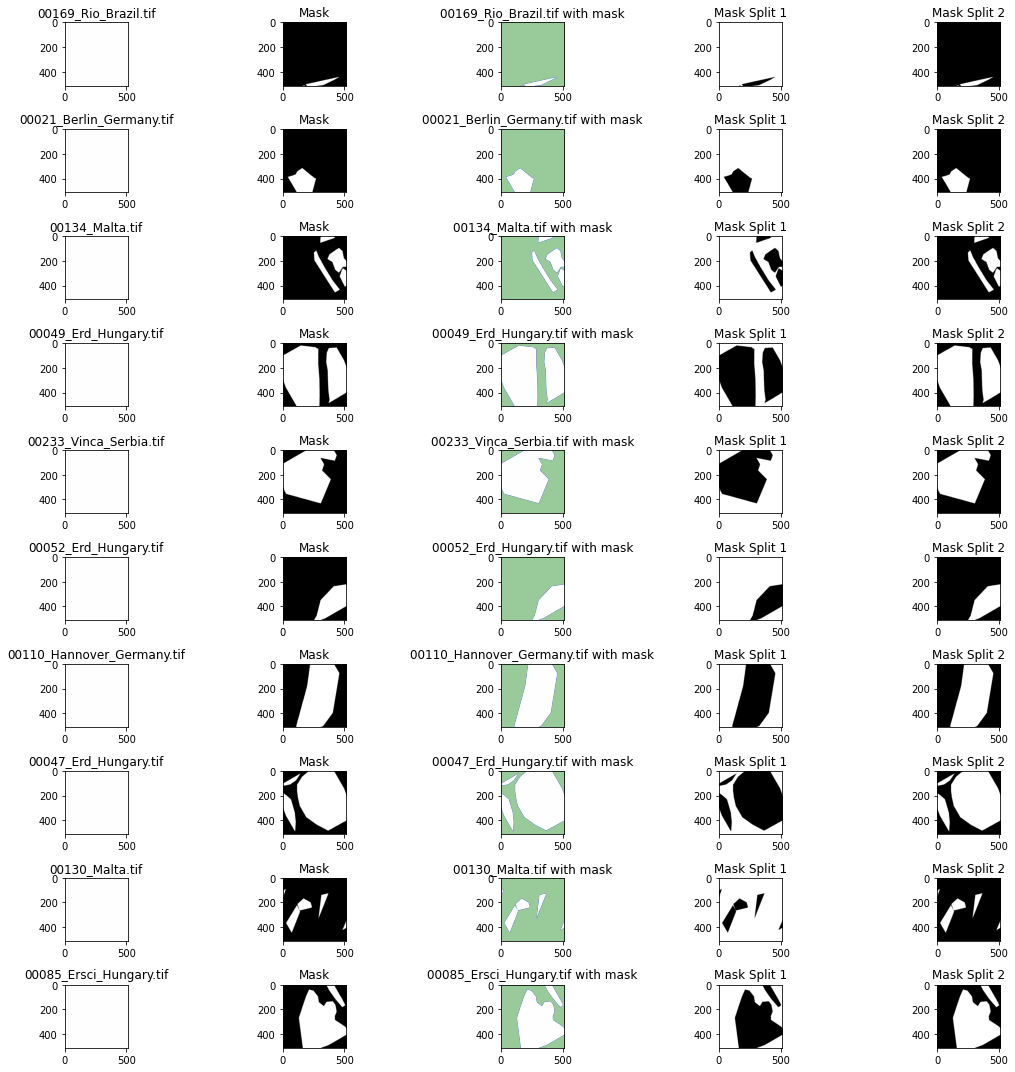

In [ ]:
count = 0
fig, axs = plt.subplots(batch_size, 5, figsize = (15, 15))

json_frame = pd.read_csv(train_labels, usecols=["json index"])
json_list = json_frame.values.tolist()

for idx in np.arange(batch_size):
  id = img_info["image_id"][idx].item()
  #print(id)
  json_name = json_list[id-1][0]
  name = img_info["name"][idx]
  #print(name)
  channels = img_info["channels"][idx].item()  
  #image = im_convert(name, channels)
  image = img_info["RGBimage"][idx].detach().numpy()
  image = image.transpose(1,2,0)
  image = image.astype('uint8')
  mask = img_info["mask"][idx].detach().numpy()
  maskHotEnc = img_info["maskHotEnc"][idx].detach().numpy()
  #print(maskHotEnc.shape)
  maskHotEnc_split = np.vsplit(maskHotEnc, 2)
  print(maskHotEnc_split[0].shape)
  axs[count][0].title.set_text(name)
  axs[count][0].imshow(image)

  axs[count][1].title.set_text('Mask')
  axs[count][1].imshow(mask, cmap='gray')

  axs[count][2].title.set_text(name+" with mask")
  axs[count][2].imshow(image)
  axs[count][2].imshow(mask, cmap='ocean', alpha=0.4)

  axs[count][3].title.set_text('Mask Split 1')
  axs[count][3].imshow(maskHotEnc_split[0].transpose(1,2,0).squeeze(), cmap='gray')

  axs[count][4].title.set_text('Mask Split 2')
  axs[count][4].imshow(maskHotEnc_split[1].transpose(1,2,0).squeeze(), cmap='gray')


  count += 1

fig.tight_layout()
  

Plot test loader images and masks

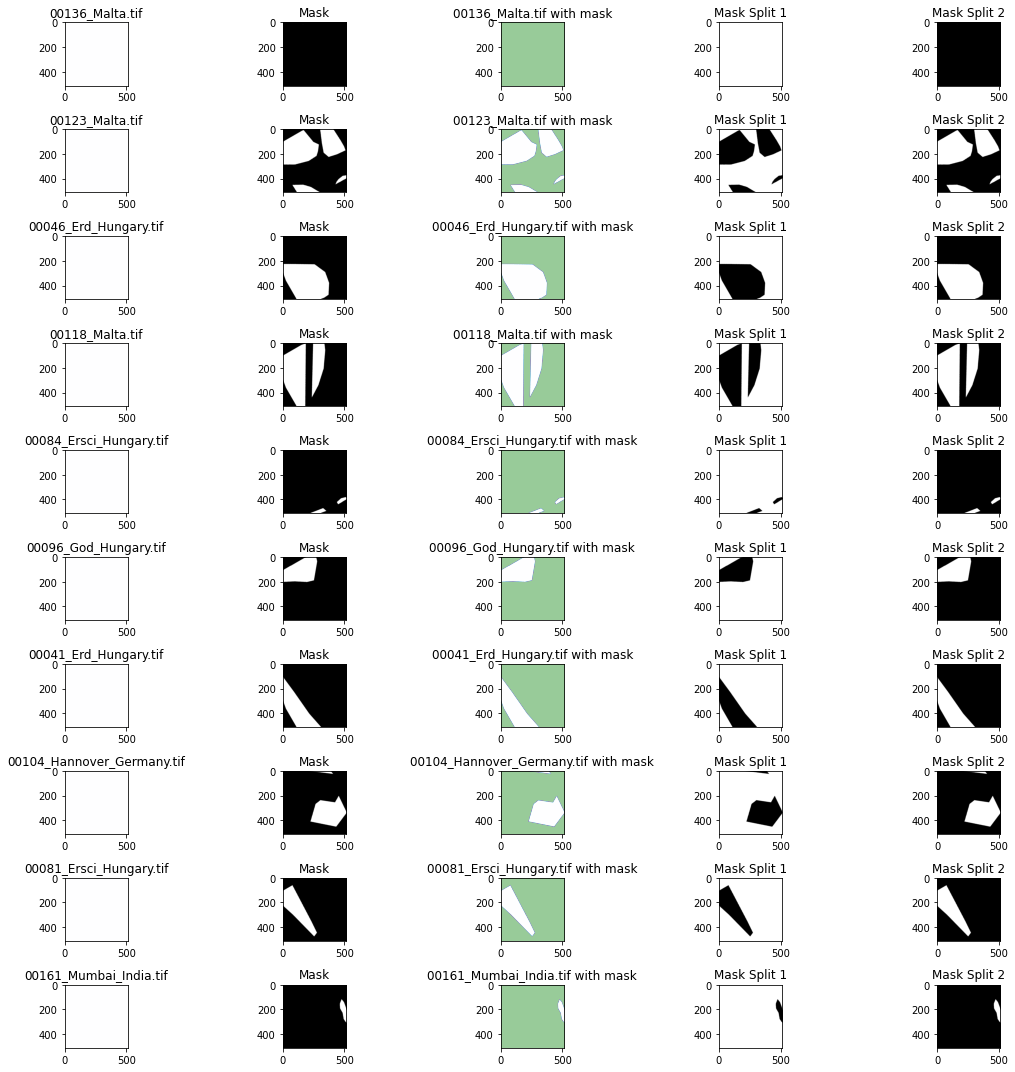

In [ ]:
count = 0
fig, axs = plt.subplots(batch_size, 5, figsize = (15, 15))


for idx in np.arange(batch_size):
  id = test_info["image_id"][idx].item()
  #print(id)
  json_name = json_list[id-1][0]
  name = test_info["name"][idx]
  #print(name)
  channels = test_info["channels"][idx].item()  
  #image = im_convert(name, channels)
  image = test_info["RGBimage"][idx].detach().numpy()
  image = image.transpose(1,2,0)
  image = image.astype('uint8')
  mask = test_info["mask"][idx].detach().numpy()
  maskHotEnc = test_info["maskHotEnc"][idx].detach().numpy()
  #print(maskHotEnc.shape)
  maskHotEnc_split = np.vsplit(maskHotEnc, 2)
  #print(maskHotEnc_split[0].shape)
  axs[count][0].title.set_text(name)
  axs[count][0].imshow(image)

  axs[count][1].title.set_text('Mask')
  axs[count][1].imshow(mask, cmap='gray')

  axs[count][2].title.set_text(name+" with mask")
  axs[count][2].imshow(image)
  axs[count][2].imshow(mask, cmap='ocean', alpha=0.4)

  axs[count][3].title.set_text('Mask Split 1')
  axs[count][3].imshow(maskHotEnc_split[0].transpose(1,2,0).squeeze(), cmap='gray')

  axs[count][4].title.set_text('Mask Split 2')
  axs[count][4].imshow(maskHotEnc_split[1].transpose(1,2,0).squeeze(), cmap='gray')


  count += 1

fig.tight_layout()
  

Training a model on the training batches

Freeze the weights until some intermediate layers to finetune the rest of the network\
https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2  \
ref: https://github.com/pochih/FCN-pytorch/tree/8436fab3586f118eb36265dab4c5f900748bb02d

FCN encoder

In [ ]:
pretrained = False
enc_model = 'vgg19'

In [ ]:
maxpool_ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

In [ ]:
def load_model(enc_model=enc_model):
  if enc_model == 'vgg11':
    model = models.vgg11(pretrained=pretrained)
  if enc_model == 'vgg13':
    model = models.vgg13(pretrained=pretrained)
  if enc_model == 'vgg16':
    model = models.vgg16(pretrained=pretrained)
  if enc_model == 'vgg19':
    model = models.vgg19(pretrained=pretrained)
  print(model)
  return model

In [ ]:
class VGGNet():
  def __init__(self, pretrained=pretrained, enc_model=enc_model, requires_grad=True, remove_fc=True):
    self.model = load_model(enc_model)
    self.model = self.model.to(device)

    self.maxpool_ranges = maxpool_ranges[enc_model]

    #use this piece of code to freeze and unfreeze layers for training

    """
    cnt = 0
    for child in self.model.children():
        for name, param in child.named_parameters():
          if cnt < 18:
            #print(name)
            param.requires_grad = False
          cnt += 1
    """

    if requires_grad == False:
      for param in self.model.parameters():
        param.requires_grad = False

    if remove_fc:
      del self.model.avgpool
      del self.model.classifier
        
    print("Params to learn:")
    for name, param in self.model.named_parameters():
      if param.requires_grad == True:
        print("\t", name, "\t", param.size())

  def forward(self, x):
    output = {}
    # get the output of each maxpooling layer (5 maxpool in VGG net)
    for idx in range(len(self.maxpool_ranges)):
        for layer in range(self.maxpool_ranges[idx][0], self.maxpool_ranges[idx][1]):
          #print(layer)
          x = self.model.features[layer](x)
        output["x%d"%(idx+1)] = x
    #print(output)
    return output

In [ ]:
VGGOut = VGGNet(enc_model=enc_model, pretrained=pretrained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

FCN decoder

In [ ]:
class FCN8s(nn.Module):
  def __init__(self, pretrained_model=VGGOut, num_classes=num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.pretrained_model = pretrained_model
    self.relu    = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1     = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn2     = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3     = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4     = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5     = nn.BatchNorm2d(32)
    self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)
    #output = self.pretrained_model.forward()
    #print(output)

  def forward(self, x):
    output = self.pretrained_model.forward(x)
    #print(output)
    x5 = output['x5']                                 # size=(N, 512, x.H/32, x.W/32)
    #print(x5)
    x4 = output['x4']                                 # size=(N, 512, x.H/16, x.W/16)
    #print(x4)
    x3 = output['x3']                                 # size=(N, 256, x.H/8,  x.W/8)
    #print(x3)

    score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
    #print(score)
    score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
    score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
    score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
    score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
    score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
    score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
    score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

    return score  # size=(N, n_class, x.H/1, x.W/1)


In [ ]:
FCN_model = FCN8s(pretrained_model=VGGOut, num_classes=num_classes)
FCN_model = FCN_model.to(device)
#out = FCN_model(rgb_img)

Loss and optimiser

In [ ]:
criterion = nn.BCEWithLogitsLoss() #BCEWithLogits()
optimizer = optim.SGD(FCN_model.parameters(), lr=lr, momentum=momentum)     #, momentum=momentum
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [ ]:
def modelPath(enc_model=enc_model):
  if(enc_model == 'vgg11'):
    model_path = './vgg_11_FCN.pth'
  if(enc_model == 'vgg13'):
    model_path = './vgg_13_FCN.pth'
  if(enc_model == 'vgg16'):
    model_path = './vgg_16_FCN.pth'
  if(enc_model == 'vgg19'):
    model_path = './vgg_19_FCN.pth'

  return model_path

K-fold prep

In [ ]:
#https://github.com/pochih/FCN-pytorch/blob/8436fab3586f118eb36265dab4c5f900748bb02d/python/train.py
model_path = modelPath(enc_model)
score_dir = './'

IU_scores    = np.zeros((epochs, num_classes))
pixel_scores = np.zeros(epochs)
val_losses_min = []
ious_mean = []
ious_ = []
total_ious = []
pixel_accs = []
train_losses = []
val_losses = []
accuracy = []
pixelAccs_mean = []

def TrainFunction():
  for epoch in range(epochs):
    t0 = time.time()
    train_loss = 0.0
    training_accuracy = 0.0
    total_train = 0.0
    correct_train = 0.0
    FCN_model.train()
    for batch, img_info in enumerate(train_loader):
      rgb_img = img_info['RGBimage']
      mask_hotEnc = img_info['maskHotEnc']
      target = img_info['mask']
      rgb_img = rgb_img.to(device)
      mask_hotEnc = mask_hotEnc.to(device)
      target = target.to(device)
      outputs = FCN_model(rgb_img)
      loss = criterion(outputs, mask_hotEnc)
      train_loss += loss.item()*rgb_img.size(0)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #accuracy
    _, predicted = torch.max(outputs, 1)
    total_train += target.nelement()
    for p, m in zip(predicted, target):
      correct_train += (p == m).sum()

    #print(total_train)
    training_accuracy = 100*(correct_train / total_train)
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    accuracy.append(training_accuracy.item())
      
    FCN_model.eval()
    total_val = 0.0
    correct_val = 0.0
    val_accuracy = 0.0
    val_loss = 0.0
    with torch.no_grad():
      for batch, img_info in enumerate(test_loader):
        rgb_img = img_info['RGBimage']
        mask_hotEnc = img_info['maskHotEnc']
        target = img_info['mask']
        rgb_img = rgb_img.to(device)
        mask_hotEnc = mask_hotEnc.to(device)
        target = target.to(device)
        outputs = FCN_model(rgb_img)
        loss = criterion(outputs, mask_hotEnc)
        val_loss += loss.item()*rgb_img.size(0)
          
        #determine performance metrics
        _, predicted = torch.max(outputs, 1)
        total_val += target.nelement()
        for p, t in zip(predicted, target):
          correct_val += (p == t).sum()

      val_accuracy = 100 * (correct_val / total_val)
      val_loss = val_loss/len(test_loader)
      pixelAccs_mean.append(val_accuracy)
      val_losses.append(val_loss)
      print("epoch: {}/{}, Training Loss in epoch:{}, validation loss: {}, training accuracy:{}, validation accuracy: {}, time elapsed: {}".format(epoch, 
                                                                                                    epochs, train_loss, val_loss, training_accuracy, val_accuracy,
                                                                                                    time.time() - t0))
      print("Saving model----->")
      torch.save(FCN_model.state_dict(), model_path)
    scheduler.step()

In [ ]:
TrainFunction()

epoch: 0/100, Training Loss in epoch:7.312346184954924, validation loss: 6.345797702670097, training accuracy:49.39469528198242, validation accuracy: 50.563133239746094, time elapsed: 22.04987645149231
Saving model----->
epoch: 1/100, Training Loss in epoch:7.188311590867884, validation loss: 6.3906455636024475, training accuracy:50.39884948730469, validation accuracy: 50.024253845214844, time elapsed: 21.89352321624756
Saving model----->
epoch: 2/100, Training Loss in epoch:7.072910964488983, validation loss: 6.415192022919655, training accuracy:51.67787551879883, validation accuracy: 50.830101013183594, time elapsed: 21.914528608322144
Saving model----->
epoch: 3/100, Training Loss in epoch:6.975618811214671, validation loss: 6.380022279918194, training accuracy:53.080326080322266, validation accuracy: 52.21332931518555, time elapsed: 21.890984296798706
Saving model----->
epoch: 4/100, Training Loss in epoch:6.890853797688203, validation loss: 6.316797219216824, training accuracy:54.

In [ ]:
def PlotLoss(train_loss, val_loss):
  print('****Loss Plot {}********')
  plt.plot(train_loss, label='Training loss')
  plt.plot(val_losses, label = 'Validation loss')
  plt.legend()

In [ ]:
def PlotAccuracy(train_accuracy, val_accuracy):
  print('*******Accuracy Plot {}**********')
  plt.plot(accuracy, label='Training pixel accuracy')
  plt.plot(pixelAccs_mean, label='Validation pixel accuracy')
  plt.legend()

****Loss Plot {}********


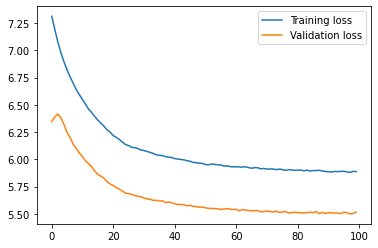

In [ ]:
PlotLoss(train_losses, val_losses)

*******Accuracy Plot {}**********


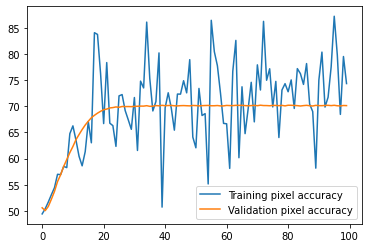

In [ ]:
PlotAccuracy(accuracy, pixelAccs_mean)

Common semantic segmentation performance metrics

In [ ]:
def iou(pred, target):
  ious = []
  for cls in range(num_classes):
    pred_inds = (pred == cls)
    target_inds = (target == cls)
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if(union == 0):
      ious.append(float('nan'))
    else:
      ious.append(float(intersection) / max(union, 1))
  #print(ious)
  return ious

Train the model and run validations

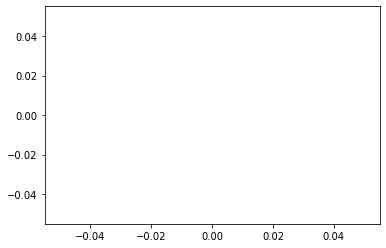

In [ ]:
plt.plot(ious_, label='IOU')
plt.plot(ious_mean, label = 'Mean IOUs')